In [1]:
import numpy as np 
import pandas as pd
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle
import sys
import xmltodict
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import time

In [2]:
torch.__version__

'1.7.1+cpu'

In [3]:
PATH_TO_DATASET = '../dataset'
PATH_TO_IMAGE = "../dataset/images"
PATH_TO_ANNOTATION = "../dataset/annotations"

In [4]:
def generate_box(obj):
    # print(obj)
    xmin = int(obj["bndbox"]["xmin"])
    ymin = int(obj["bndbox"]["ymin"])
    xmax = int(obj["bndbox"]["xmax"])
    ymax = int(obj["bndbox"]["ymax"])

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    """
    with mask -> 1
    wear incorrect or not wear -> 0
    """
    if obj["name"] == "with_mask":
        return 1
    elif obj["name"] == "without_mask" or obj["name"] == "mask_weared_incorrect":
        return 2
    else:
        return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = xmltodict.parse(f.read())
        
        objects = data["annotation"]["object"]
        
        # BBOX for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        if type(objects) == list:
            for i in objects:
                boxes.append(generate_box(i))
                labels.append(generate_label(i))
        else:
            boxes.append(generate_box(objects))
            labels.append(generate_label(objects))
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [5]:
imgs = list(sorted(os.listdir(PATH_TO_IMAGE)))
annotations = list(sorted(os.listdir(PATH_TO_ANNOTATION)))
print(imgs[:3], annotations[:3])

['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png'] ['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml']


In [6]:
class MaskDataset(Dataset):
    def __init__(self, transforms):
        super().__init__()
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(PATH_TO_IMAGE)))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(PATH_TO_IMAGE, file_image)
        label_path = os.path.join(PATH_TO_ANNOTATION, file_label)
        img = Image.open(img_path).convert("RGB")
        
        target = generate_target(idx, label_path)
        
        if self.transforms != None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [8]:
def collate_fn(batch):
    # print(*batch)
    return tuple(zip(*batch))

In [9]:
dataset = MaskDataset(data_transform)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(f"Dataset Length: {len(dataset)}, train_size: {train_size}, test_size: {test_size}")

Dataset Length: 853, train_size: 682, test_size: 171


In [10]:
trainset, testset=torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(100))

In [11]:
trainDataLoader = DataLoader(trainset, batch_size=8, shuffle=True, collate_fn=collate_fn)
testDataLoader = DataLoader(testset, batch_size=1, collate_fn=collate_fn)

In [12]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)

    return model

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
model = get_model_instance_segmentation(2)

In [15]:
for imgs, annotations in trainDataLoader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[103., 231., 181., 338.]]), 'labels': tensor([1]), 'image_id': tensor([355])}, {'boxes': tensor([[ 42.,  54.,  94., 110.],
        [188.,  46., 236., 106.],
        [261.,  88., 303., 130.],
        [368., 112., 400., 151.]]), 'labels': tensor([1, 1, 1, 1]), 'image_id': tensor([103])}, {'boxes': tensor([[  2.,  28.,  19.,  46.],
        [ 23.,  36.,  45.,  59.],
        [ 30.,  71.,  51.,  92.],
        [  4., 177.,  35., 209.],
        [ 93.,  15., 117.,  34.],
        [ 99.,  74., 122., 100.],
        [ 56., 132.,  79., 162.],
        [ 36., 152.,  65., 183.],
        [138., 191., 165., 221.],
        [182.,  13., 209.,  36.],
        [188.,  55., 213.,  80.],
        [196., 146., 219., 168.],
        [213., 164., 243., 193.],
        [253.,  13., 277.,  35.],
        [246.,  73., 268.,  98.],
        [286.,  10., 314.,  38.],
        [320.,   1., 341.,  15.],
        [345.,  34., 372.,  57.],
        [358., 116., 388., 141.]]), 'labels': tensor([1, 1, 2, 1, 1, 1, 

## Train

In [16]:
num_epochs = 50
model.to(device)
loss_log = []
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
batches = len(trainDataLoader)
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time_epoch = time.time()
    for i, (imgs, annotations) in enumerate(trainDataLoader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        if i % 20 == 0:
            print(f"Epoch: {epoch}, Batch: {i}/{batches}, Loss: {losses}")
        epoch_loss += losses
    end_time_epoch = time.time()
    print(f"Epoch {epoch} total loss: {epoch_loss}, time: {end_time_epoch - start_time_epoch}")
    loss_log.append(epoch_loss)
    print("----------")

end_time = time.time()
print(f"Running time {end_time - start_time}")

torch.save(model.state_dict(),'./model2_2.pt')

Epoch: 0, Batch: 20/86, Loss: 3.7302637100219727
Epoch: 0, Batch: 40/86, Loss: 1.2504843473434448
Epoch: 0, Batch: 60/86, Loss: 0.165103942155838
Epoch: 0, Batch: 80/86, Loss: 1.2268754243850708
Epoch 0 total loss: 61.589561462402344, time: 269.9383223056793
----------
Epoch: 1, Batch: 20/86, Loss: 0.841736912727356
Epoch: 1, Batch: 40/86, Loss: 0.5667648315429688
Epoch: 1, Batch: 60/86, Loss: 0.12030111998319626
Epoch: 1, Batch: 80/86, Loss: 0.5049957036972046
Epoch 1 total loss: 40.048213958740234, time: 273.2753732204437
----------
Epoch: 2, Batch: 20/86, Loss: 0.2021433562040329
Epoch: 2, Batch: 40/86, Loss: 0.08157635480165482
Epoch: 2, Batch: 60/86, Loss: 0.2759018540382385
Epoch: 2, Batch: 80/86, Loss: 0.06815021485090256
Epoch 2 total loss: 31.549497604370117, time: 269.3283989429474
----------
Epoch: 3, Batch: 20/86, Loss: 0.04943527653813362
Epoch: 3, Batch: 40/86, Loss: 0.14260907471179962
Epoch: 3, Batch: 60/86, Loss: 0.06373550742864609
Epoch: 3, Batch: 80/86, Loss: 0.7461

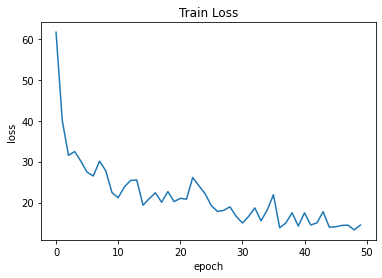

In [44]:
loss_record=[
    52.99475860595703, 40.772029876708984, 29.405611038208008, 30.507911682128906, 32.67216110229492, 
    26.49441146850586, 20.494503021240234, 24.44652557373047, 25.322792053222656, 25.898418426513672,
    23.598398208618164, 22.025501251220703, 19.358423233032227, 24.80889320373535, 21.606704711914062,
    20.622028350830078, 22.94870376586914, 23.799055099487305, 23.186620712280273, 21.728010177612305]
plt.plot(loss_log)
plt.xlabel('epoch') 
plt.ylabel('loss') 
  
# displaying the title
plt.title("Train Loss")
# plt.savefig("./train_loss.jpg")

## Evaluation

In [17]:
model.load_state_dict(torch.load("./model2.pt"))

<All keys matched successfully>

In [38]:
for i, (imgs, annotations) in enumerate(testDataLoader):
    if i<35:
        continue
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break
print(annotations)

[{'boxes': tensor([[ 96.,  74., 136., 127.],
        [193., 100., 234., 146.],
        [259., 105., 305., 151.],
        [334., 106., 367., 144.]]), 'labels': tensor([1, 1, 1, 2]), 'image_id': tensor([334])}]


In [39]:
model.eval()
preds = model(imgs)

In [40]:
preds

[{'boxes': tensor([[258.2983, 104.6686, 306.7988, 150.3312],
          [191.3557, 100.7636, 232.8339, 148.2414],
          [ 95.9136,  75.3872, 135.3266, 127.0780],
          [336.0060, 105.4967, 372.4033, 144.0760],
          [ 94.7554,  75.4603, 135.2807, 123.0913]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 2, 2]),
  'scores': tensor([0.9957, 0.9933, 0.9814, 0.9232, 0.1586], grad_fn=<IndexBackward>)}]

In [41]:
def plot_image(img_tensor, annotation, threshold=None):
    
    fig, ax = plt.subplots(1)
    img = img_tensor.cpu().data
    framecolor={1: 'g', 2: 'r', 0: 'b'}

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    if not threshold:
        annotation["scores"] = [1.0] * len(annotation["labels"])
    
    for box, label, score in zip(annotation["boxes"], annotation["labels"], annotation["scores"]):
        xmin, ymin, xmax, ymax = box
        xmin = float(xmin)
        ymin = float(ymin)
        xmax = float(xmax)
        ymax = float(ymax)
        label = int(label)
        score = float(score)

        if threshold and score < threshold:
            continue
        # Create a Rectangle patch
        rect = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                  linewidth=1, edgecolor=framecolor[label], facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


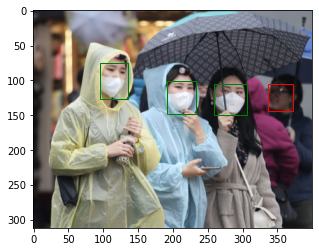

Target


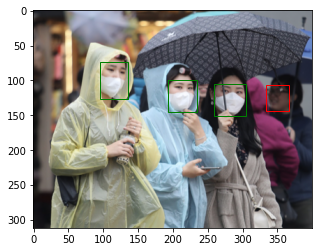

In [42]:
print("Prediction")
plot_image(imgs[0], preds[0], 0.5)
print("Target")
plot_image(imgs[0], annotations[0])